In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/circ/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)


2023-09-05 10:01:36,408 - hbmep.config - INFO - Verifying configuration ...
2023-09-05 10:01:36,409 - hbmep.config - INFO - Success!
2023-09-05 10:01:36,421 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-09-05 10:01:36,439 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/L_CIRC/fcr
2023-09-05 10:01:36,440 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/L_CIRC/fcr
2023-09-05 10:01:36,440 - hbmep.dataset.core - INFO - Processing data ...
2023-09-05 10:01:36,442 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
combinations = model._make_combinations(df=df, columns=model.combination_columns)   # sub x pos x size
combinations_inv = [
    (
        encoder_dict[model.subject].inverse_transform(np.array([c[0]]))[0],
        encoder_dict[model.features[0]].inverse_transform(np.array([c[1]]))[0],
    ) for c in combinations
]

positions_inv = encoder_dict[model.features[0]].classes_.tolist()
positions = encoder_dict[model.features[0]].transform(np.array(positions_inv)).tolist()

In [4]:
len(positions)

21

In [5]:
muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]
a = None

for muscle in muscles:
    a_muscle = None

    for i, c in enumerate(combinations):
        c_inv = combinations_inv[i]
        src = f"/home/vishu/repos/hbmep-paper/reports/L_CIRC/{muscle}/iterative/{c_inv[0]}/{c_inv[1]}"

        mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]
        a_temp = mcmc[site.a].to_numpy()
        a_temp = a_temp[..., 0, 0, 0]
        a_temp = a_temp[..., None]

        if a_muscle is None:
            a_muscle = a_temp
        else:
            a_muscle = np.concatenate((a_muscle, a_temp), axis=-1)

    a_muscle = a_muscle[..., None]

    if a is None:
        a = a_muscle
    else:
        a = np.concatenate((a, a_muscle), axis=-1)

KeyboardInterrupt: 

In [ ]:
a.shape

(4, 6000, 168, 6)

In [ ]:
t = az.summary({"a": a})

In [ ]:
t.shape

(1008, 9)

In [ ]:
(t.r_hat > 1.05).sum()

16

In [ ]:
t.r_hat.max()

1.53

In [ ]:
a = a.reshape(-1, *a.shape[2:])
a = np.array(jax.random.permutation(model.rng_key, x=a, axis=0, independent=True))

a.shape

(24000, 168, 6)

In [ ]:
a_map = a.mean(axis=0)
a_map.shape

(168, 6)

In [ ]:
def _process(keep_positions: list, keep_muscles: list[str], threshold: int):
    keep_muscles_ind = [i for i, muscle in enumerate(muscles) if muscle in keep_muscles]

    pr = []
    effect_size = []
    t_test = []
    rank_test = []
    heat_map = []
    mask = []

    for i, i_pos in enumerate(keep_positions):
        curr_pr = []
        curr_effect_size = []
        curr_t_test = []
        curr_rank_test = []
        curr_heat_map = []
        curr_mask = []

        for j, j_pos in enumerate(keep_positions):
            if i == j:
                curr_pr.append(0)
                curr_effect_size.append((0, 0))
                curr_t_test.append(1)
                curr_rank_test.append(1)
                curr_heat_map.append(f"D")
                curr_mask.append(False)
                continue

            i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
            j_com = [(j, c) for j, c in enumerate(combinations) if c[1] == j_pos]

            i_com = sorted(i_com, key=lambda x: x[1][0])
            j_com = sorted(j_com, key=lambda x: x[1][0])

            i_sub = set([v[1][0] for v in i_com])
            j_sub = set([v[1][0] for v in j_com])
            common_sub = list(i_sub.intersection(j_sub))

            i_ind = [v[0] for v in i_com if v[1][0] in common_sub]
            j_ind = [v[0] for v in j_com if v[1][0] in common_sub]

            N = len(common_sub) * len(keep_muscles_ind)

            if not len(common_sub) or len(common_sub) < threshold:
                curr_pr.append(0)
                curr_effect_size.append((0, 0))
                curr_t_test.append(1)
                curr_rank_test.append(1)
                curr_heat_map.append(f"NA:0")
                curr_mask.append(False)
                continue

            curr_mask.append(True)

            ## Distributions
            i_a = a[:, i_ind, ...]
            i_a = i_a[..., keep_muscles_ind]
            i_a = i_a.reshape(i_a.shape[0], -1)

            j_a = a[:, j_ind, ...]
            j_a = j_a[..., keep_muscles_ind]
            j_a = j_a.reshape(j_a.shape[0], -1)

            diff_a = i_a - j_a
            diff_a_mu = diff_a.mean(axis=-1)
            pr_a_mu = (diff_a_mu < 0).mean()
            curr_pr.append(pr_a_mu)

            ## Effect-size
            i_mu_a_estimate = i_a.mean(axis=-1)
            i_sigma_sq_a_estimate = np.power(i_a - i_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

            j_mu_a_estimate = j_a.mean(axis=-1)
            j_sigma_sq_a_estimate = np.power(j_a - j_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

            i_j_effect_size = (i_mu_a_estimate - j_mu_a_estimate) / np.power( (i_sigma_sq_a_estimate + j_sigma_sq_a_estimate) / 2, 0.5)
            hpdi_interval_lo, hpdi_interval_hi = hpdi(i_j_effect_size, prob=.95)
            curr_effect_size.append((hpdi_interval_lo, hpdi_interval_hi))

            curr_heat_map.append(f"{pr_a_mu:.2f}:{len(common_sub)}\n({hpdi_interval_lo:.2f}, {hpdi_interval_hi:.2f})")

            ## MAP
            i_map = a_map[i_ind, ...]
            i_map = i_map[..., keep_muscles_ind]
            i_map = i_map.reshape(-1,)

            j_map = a_map[j_ind, ...]
            j_map = j_map[..., keep_muscles_ind]
            j_map = j_map.reshape(-1,)

            diff_map = i_map - j_map
            t_test_map = stats.ttest_1samp(a=diff_map, popmean=0, alternative="less")
            rank_test_map = stats.wilcoxon(x=diff_map, alternative="less")

            curr_t_test.append(t_test_map.pvalue)
            curr_rank_test.append(rank_test_map.pvalue)

        pr.append(curr_pr)
        effect_size.append(curr_effect_size)
        t_test.append(curr_t_test)
        rank_test.append(curr_rank_test)
        heat_map.append(curr_heat_map)
        mask.append(curr_mask)

    pr = np.array(pr)
    effect_size = np.array(effect_size)
    t_test = np.array(t_test)
    rank_test = np.array(rank_test)
    heat_map = np.array(heat_map)
    mask = np.array(mask)

    return pr, effect_size, t_test, rank_test, heat_map, mask

#### Efficacy

In [ ]:
# nrows, ncols = 2, 3
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(21 * ncols, 21 * nrows), constrained_layout=True)

# for i, muscle in enumerate(muscles):
#     ax = axes[i // ncols, i % ncols]

#     keep_muscles = [muscle]
#     keep_positions = positions
#     n_positions = len(keep_positions)

#     keep_positions_inv = encoder_dict[model.features[0]].inverse_transform(np.array(positions)).tolist()

#     pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_positions=keep_positions, keep_muscles=keep_muscles, threshold=1)

#     ind = list(zip(
#         range(pr.shape[0]),
#         (pr > .95).sum(axis=1) / mask.sum(axis=1),
#         pr.sum(axis=1).tolist() / mask.sum(axis=1)
#     ))

#     ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
#     ind = [v[0] for v in ind]

#     sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind], ax=ax)
#     sns.heatmap(
#         pr[ind, :][:, ind],
#         annot=heat_map[ind, :][:, ind],
#         annot_kws={'va':'bottom'},
#         fmt="",
#         cbar=False,
#         xticklabels=np.array(keep_positions_inv)[ind],
#         yticklabels=np.array(keep_positions_inv)[ind],
#         mask=~mask[ind, :][:, ind],
#         ax=ax
#     )

#     ax.tick_params(labeltop=True, labelbottom=False)
#     ax.set_xticklabels(np.array(keep_positions_inv)[ind], rotation=75)
#     ax.set_title(f'{", ".join(keep_muscles)}');

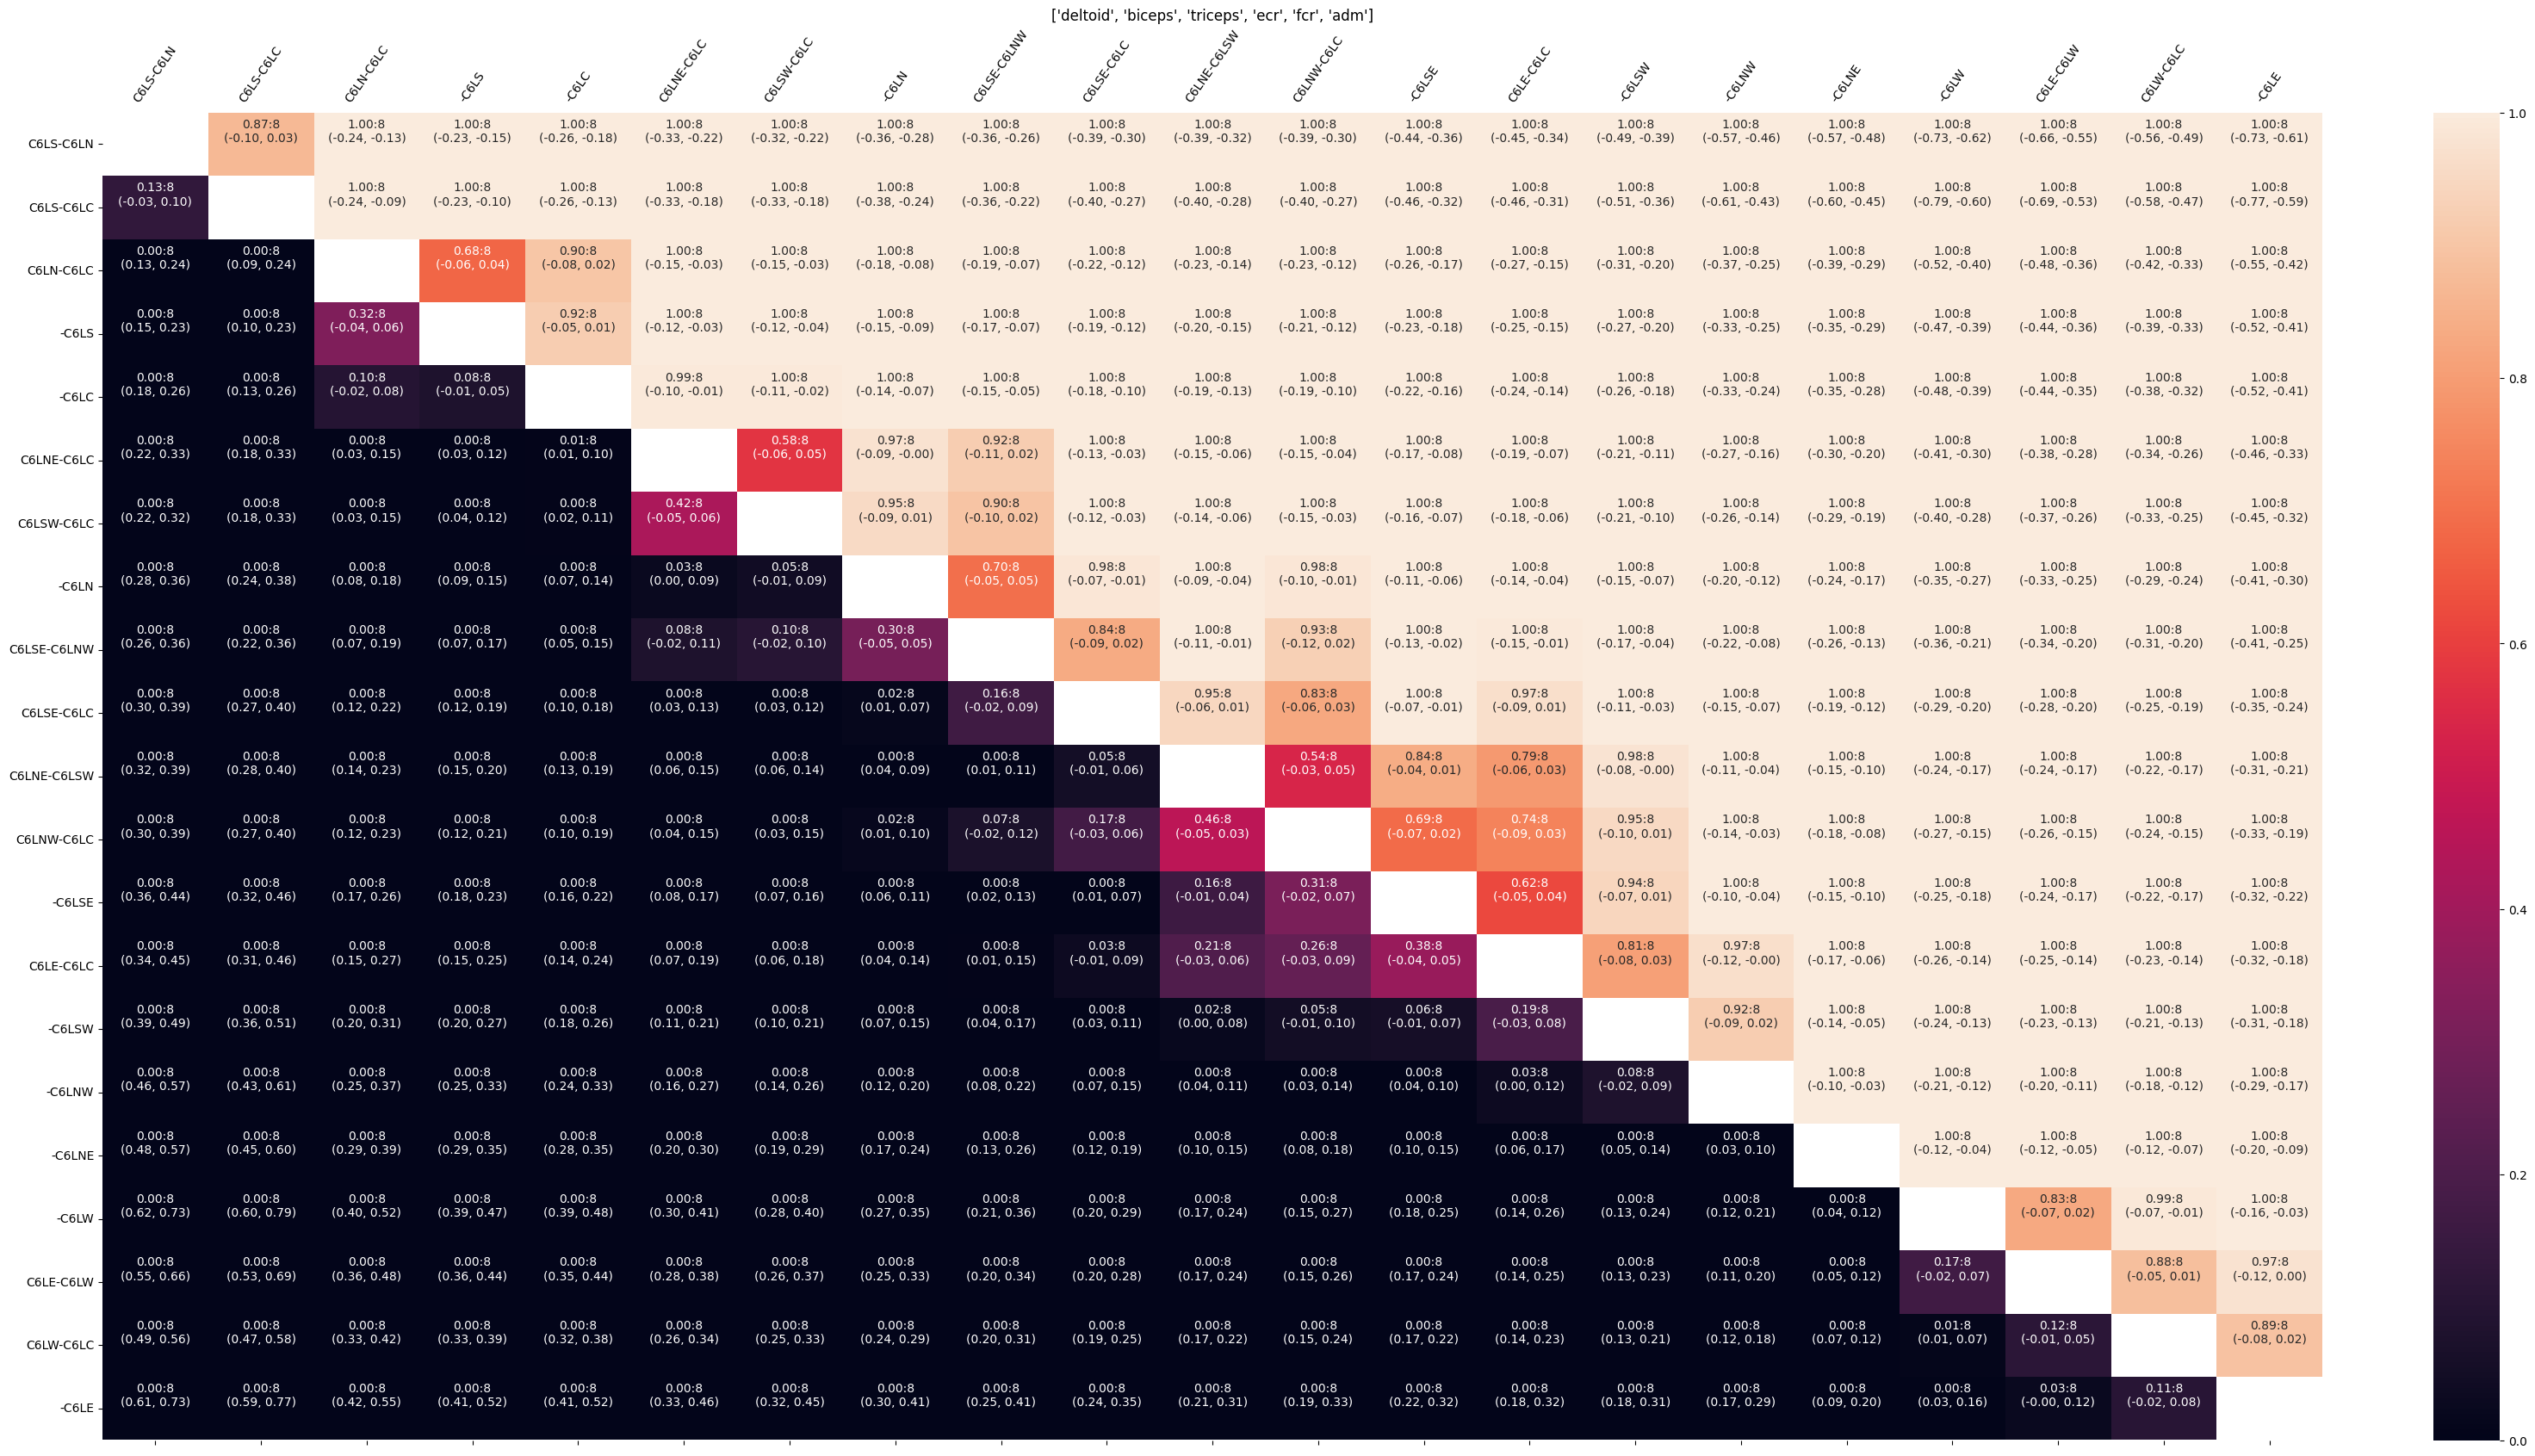

In [ ]:
keep_muscles = muscles

keep_positions = positions
n_positions = len(keep_positions)

keep_positions_inv = encoder_dict[model.features[0]].inverse_transform(np.array(positions)).tolist()

pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_positions=keep_positions, keep_muscles=keep_muscles, threshold=1)

plt.figure(figsize=(1.4 * n_positions, .8 * n_positions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_positions_inv)[ind],
    yticklabels=np.array(keep_positions_inv)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=55)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [ ]:
efficacy_score = {}


In [ ]:
key = "all"
efficacy_score[key] = {}

for i, c in enumerate(np.array(keep_positions_inv)[ind].tolist()):
    efficacy_score[key][c] = [n_positions - i]

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    c_inv = keep_positions_inv[i]
    efficacy_score[key][c_inv].append(i_a.mean())

efficacy_score[key]

{'C6LS-C6LN': [21, 89.03413262159502],
 'C6LS-C6LC': [20, 93.1200984485746],
 'C6LN-C6LC': [19, 111.6398518518112],
 '-C6LS': [18, 112.97451662302753],
 '-C6LC': [17, 115.6346878916104],
 'C6LNE-C6LC': [16, 122.67053577456463],
 'C6LSW-C6LC': [15, 123.36332329236447],
 '-C6LN': [14, 128.37375168070494],
 'C6LSE-C6LNW': [13, 129.64601952252158],
 'C6LSE-C6LC': [12, 133.4163009105916],
 'C6LNE-C6LSW': [11, 136.97908458412775],
 'C6LNW-C6LC': [10, 136.70278102797974],
 '-C6LSE': [9, 138.54825828595372],
 'C6LE-C6LC': [8, 139.49466000271585],
 '-C6LSW': [7, 142.45991855972105],
 '-C6LNW': [6, 146.53182955341543],
 '-C6LNE': [5, 153.92762546965983],
 '-C6LW': [4, 162.34223242108442],
 'C6LE-C6LW': [3, 164.8476514862262],
 'C6LW-C6LC': [2, 167.9934032166982],
 '-C6LE': [1, 172.62143594596125]}

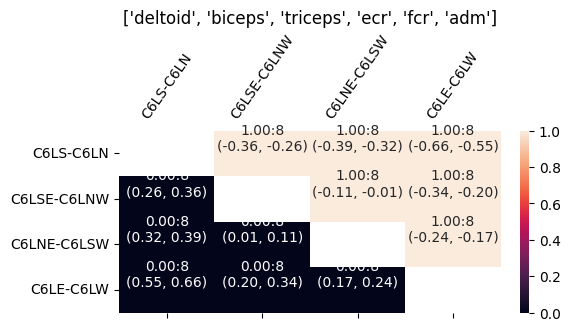

In [ ]:
# Diameters
keep_muscles = muscles
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] != "C"]
keep_positions = encoder_dict[model.features[0]].transform(np.array(keep_positions_inv)).tolist()

n_positions = len(keep_positions)

pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_positions=keep_positions, keep_muscles=keep_muscles, threshold=1)

plt.figure(figsize=(1.4 * n_positions, .8 * n_positions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_positions_inv)[ind],
    yticklabels=np.array(keep_positions_inv)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=55)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [ ]:
key = "diameters"
efficacy_score[key] = {}

for i, c in enumerate(np.array(keep_positions_inv)[ind].tolist()):
    efficacy_score[key][c] = [n_positions - i]

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    c_inv = keep_positions_inv[i]
    efficacy_score[key][c_inv].append(i_a.mean())

efficacy_score[key]

{'C6LS-C6LN': [4, 89.03413262159502],
 'C6LSE-C6LNW': [3, 129.64601952252158],
 'C6LNE-C6LSW': [2, 136.97908458412775],
 'C6LE-C6LW': [1, 164.8476514862262]}

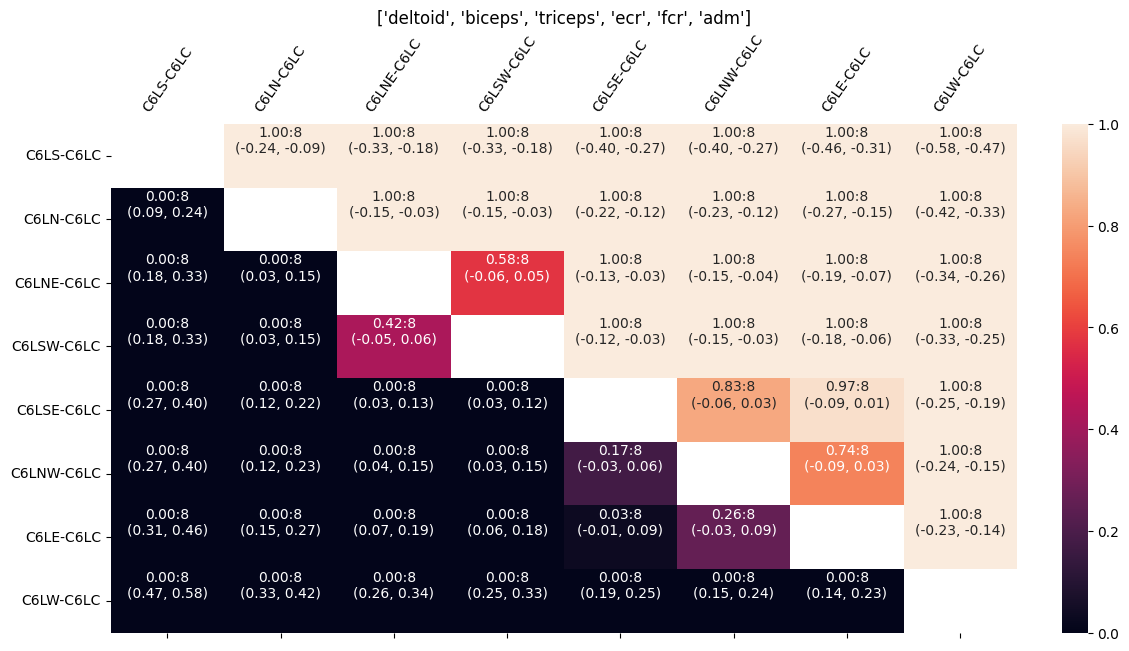

In [ ]:
# Radii
keep_muscles = muscles
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] == "C"]
keep_positions = encoder_dict[model.features[0]].transform(np.array(keep_positions_inv)).tolist()

n_positions = len(keep_positions)

pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_positions=keep_positions, keep_muscles=keep_muscles, threshold=1)

plt.figure(figsize=(1.4 * n_positions, .8 * n_positions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_positions_inv)[ind],
    yticklabels=np.array(keep_positions_inv)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=55)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [ ]:
key = "radii"
efficacy_score[key] = {}

for i, c in enumerate(np.array(keep_positions_inv)[ind].tolist()):
    efficacy_score[key][c] = [n_positions - i]

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    c_inv = keep_positions_inv[i]
    efficacy_score[key][c_inv].append(i_a.mean())

efficacy_score[key]

{'C6LS-C6LC': [8, 93.1200984485746],
 'C6LN-C6LC': [7, 111.6398518518112],
 'C6LNE-C6LC': [6, 122.67053577456463],
 'C6LSW-C6LC': [5, 123.36332329236447],
 'C6LSE-C6LC': [4, 133.4163009105916],
 'C6LNW-C6LC': [3, 136.70278102797974],
 'C6LE-C6LC': [2, 139.49466000271585],
 'C6LW-C6LC': [1, 167.9934032166982]}

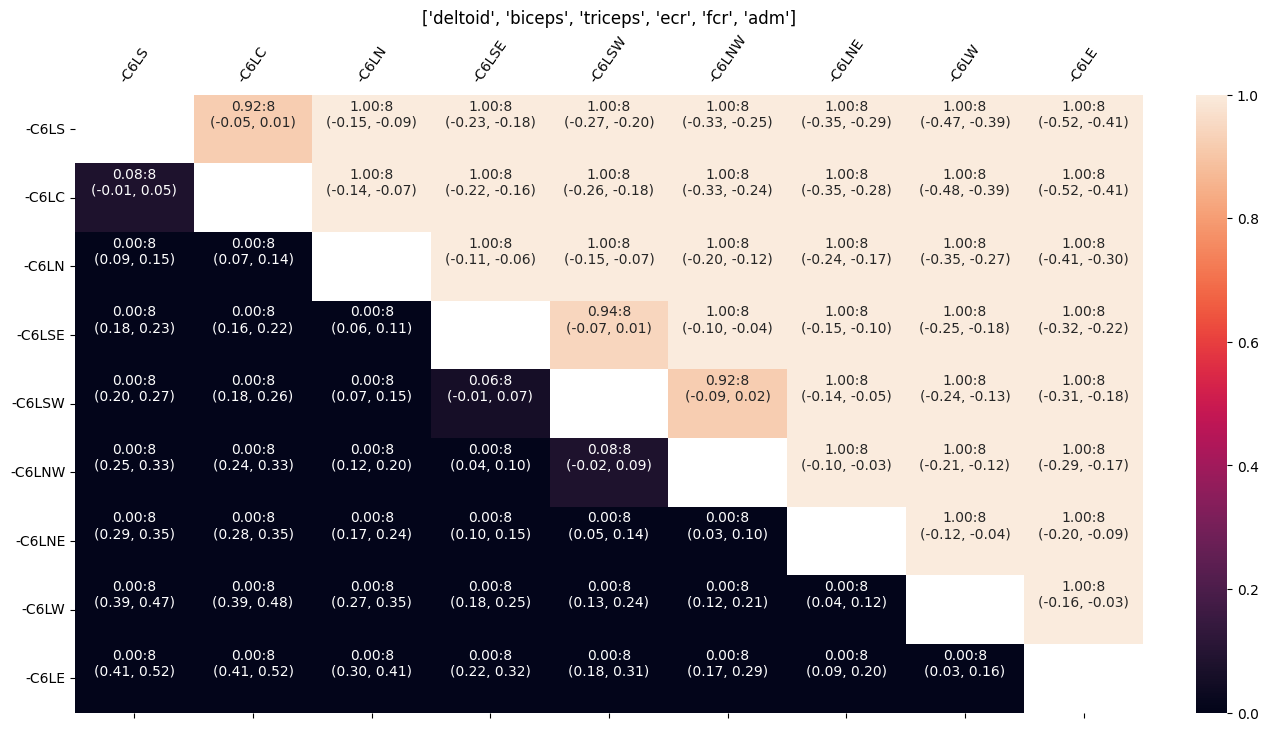

In [ ]:
# Vertices
keep_muscles = muscles
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] == ""]
keep_positions = encoder_dict[model.features[0]].transform(np.array(keep_positions_inv)).tolist()

n_positions = len(keep_positions)

pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_positions=keep_positions, keep_muscles=keep_muscles, threshold=1)

plt.figure(figsize=(1.4 * n_positions, .8 * n_positions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_positions_inv)[ind],
    yticklabels=np.array(keep_positions_inv)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=55)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [ ]:
key = "vertices"
efficacy_score[key] = {}

for i, c in enumerate(np.array(keep_positions_inv)[ind].tolist()):
    efficacy_score[key][c] = [n_positions - i]

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    c_inv = keep_positions_inv[i]
    efficacy_score[key][c_inv].append(i_a.mean())

efficacy_score[key]

{'-C6LS': [9, 112.97451662302753],
 '-C6LC': [8, 115.6346878916104],
 '-C6LN': [7, 128.37375168070494],
 '-C6LSE': [6, 138.54825828595372],
 '-C6LSW': [5, 142.45991855972105],
 '-C6LNW': [4, 146.53182955341543],
 '-C6LNE': [3, 153.92762546965983],
 '-C6LW': [2, 162.34223242108442],
 '-C6LE': [1, 172.62143594596125]}

#### Selectivity

In [ ]:
muscles_map = {
    "adm": "auc_1",
    "biceps": "auc_2",
    "deltoid": "auc_4",
    "ecr": "auc_5",
    "fcr": "auc_6",
    "triceps": "auc_7"
}

n_muscles = len(muscles)

In [ ]:
a = None
b = None
L = None
H = None
v = None

for muscle in muscles:
    a_muscle = None
    b_muscle = None
    L_muscle = None
    H_muscle = None
    v_muscle = None

    for i, c in enumerate(combinations):
        c_inv = combinations_inv[i]
        src = f"/home/vishu/repos/hbmep-paper/reports/L_CIRC/{muscle}/iterative/{c_inv[0]}/{c_inv[1]}"
        mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]

        a_temp = mcmc[site.a].to_numpy()
        a_temp = a_temp[..., 0, 0, 0]
        a_temp = a_temp[..., None]

        b_temp = mcmc[site.b].to_numpy()
        b_temp = b_temp[..., 0, 0, 0]
        b_temp = b_temp[..., None]

        L_temp = mcmc[site.L].to_numpy()
        L_temp = L_temp[..., 0, 0, 0]
        L_temp = L_temp[..., None]

        H_temp = mcmc[site.H].to_numpy()
        H_temp = H_temp[..., 0, 0, 0]
        H_temp = H_temp[..., None]

        v_temp = mcmc[site.v].to_numpy()
        v_temp = v_temp[..., 0, 0, 0]
        v_temp = v_temp[..., None]

        if a_muscle is None:
            a_muscle = a_temp
            b_muscle = b_temp
            L_muscle = L_temp
            H_muscle = H_temp
            v_muscle = v_temp
        else:
            a_muscle = np.concatenate((a_muscle, a_temp), axis=-1)
            b_muscle = np.concatenate((b_muscle, b_temp), axis=-1)
            L_muscle = np.concatenate((L_muscle, L_temp), axis=-1)
            H_muscle = np.concatenate((H_muscle, H_temp), axis=-1)
            v_muscle = np.concatenate((v_muscle, v_temp), axis=-1)

    a_muscle = a_muscle[..., None]
    b_muscle = b_muscle[..., None]
    L_muscle = L_muscle[..., None]
    H_muscle = H_muscle[..., None]
    v_muscle = v_muscle[..., None]

    if a is None:
        a = a_muscle
        b = b_muscle
        L = L_muscle
        H = H_muscle
        v = v_muscle
    else:
        a = np.concatenate((a, a_muscle), axis=-1)
        b = np.concatenate((b, b_muscle), axis=-1)
        L = np.concatenate((L, L_muscle), axis=-1)
        H = np.concatenate((H, H_muscle), axis=-1)
        v = np.concatenate((v, v_muscle), axis=-1)

In [ ]:
a = a.reshape(-1, *a.shape[2:])
b = b.reshape(-1, *b.shape[2:])
L = L.reshape(-1, *L.shape[2:])
H = H.reshape(-1, *H.shape[2:])
v = v.reshape(-1, *v.shape[2:])

In [ ]:
a.shape

(24000, 168, 6)

In [ ]:
x = None

for muscle in muscles:
    x_muscle = None

    for i, c in enumerate(combinations):
        ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        lo, hi = temp_df[model.intensity].min(), temp_df[model.intensity].max()
        x_temp = np.linspace(lo, hi, 100)
        x_temp = x_temp[..., None]

        if x_muscle is None:
            x_muscle = x_temp
        else:
            x_muscle = np.concatenate((x_muscle, x_temp), axis=-1)

    x_muscle = x_muscle[..., None]

    if x is None:
        x = x_muscle
    else:
        x = np.concatenate((x, x_muscle), axis=-1)

x = x[:, None, ...]

In [ ]:
x.shape

(100, 1, 168, 6)

In [ ]:
a.shape

(24000, 168, 6)

In [ ]:
y = L + jnp.maximum(
    0,
    -1
    + (H + 1)
    / jnp.power(
        1
        + (jnp.power(1 + H, v) - 1)
        * jnp.exp(-b * (x - a)),
        1 / v
    )
)

y.shape

In [ ]:
y_map = y.mean(axis=1)
y_map.shape

(100, 168, 6)

In [ ]:
y.min()

Array(0., dtype=float64)

In [ ]:
y.max()

Array(40.13523225, dtype=float64)

In [ ]:
y_max = None

for i, (sub, pos) in enumerate(combinations):
    com = [(j, c) for j, c in enumerate(combinations) if c[0] == sub]
    ind = [v[0] for v in com]
    y_max_temp = y_map[:, ind, ...].max(axis=(0, 1))
    y_max_temp = y_max_temp[None, ...]

    if y_max is None:
        y_max = y_max_temp
    else:
        y_max = np.concatenate((y_max, y_max_temp), axis=0)

y_max = y_max[None, None , ...]

y_max.shape

(1, 1, 168, 6)

In [ ]:
y_max.min()

0.19772280709510737

In [ ]:
y_max.max()

27.777866466664925

In [ ]:
y_map.min()

Array(0., dtype=float64)

In [ ]:
y_map.max()

Array(27.77786647, dtype=float64)

In [ ]:
y = y / y_max       # valid bc y_max.min() > 0

In [ ]:
y_ratio = y / y.sum(axis=-1)[..., None]

In [ ]:
y_ratio.min()

(100, 24000, 168, 6)

In [39]:
import gc

del y, b, L, H, v
gc.collect()

0

In [40]:
entropy_adj = 1 + (
    (y_ratio * jnp.log(y_ratio)).sum(axis=-1)
    / jnp.log(n_muscles)
)
entropy_adj.shape

(100, 24000, 168)

In [41]:
entropy_adj = np.array(jax.random.permutation(model.rng_key, x=entropy_adj, axis=1, independent=True))
entropy_adj.shape

(100, 24000, 168)

In [42]:
entropy_adj_map = entropy_adj.mean(axis=1)
entropy_adj_map.shape

(100, 168)

In [44]:
y_ratio.shape

(100, 24000, 168, 6)

In [43]:
entropy_adj_hpdi = hpdi(entropy_adj, axis=1)
entropy_adj_hpdi.shape

(100, 2, 168)

In [44]:
a_map.shape

(168, 6)

In [45]:
x.shape

(100, 1, 168, 6)

In [46]:
x.max(axis=-1).shape

(100, 1, 168)

In [47]:
entropy_adj.shape

(100, 24000, 168)

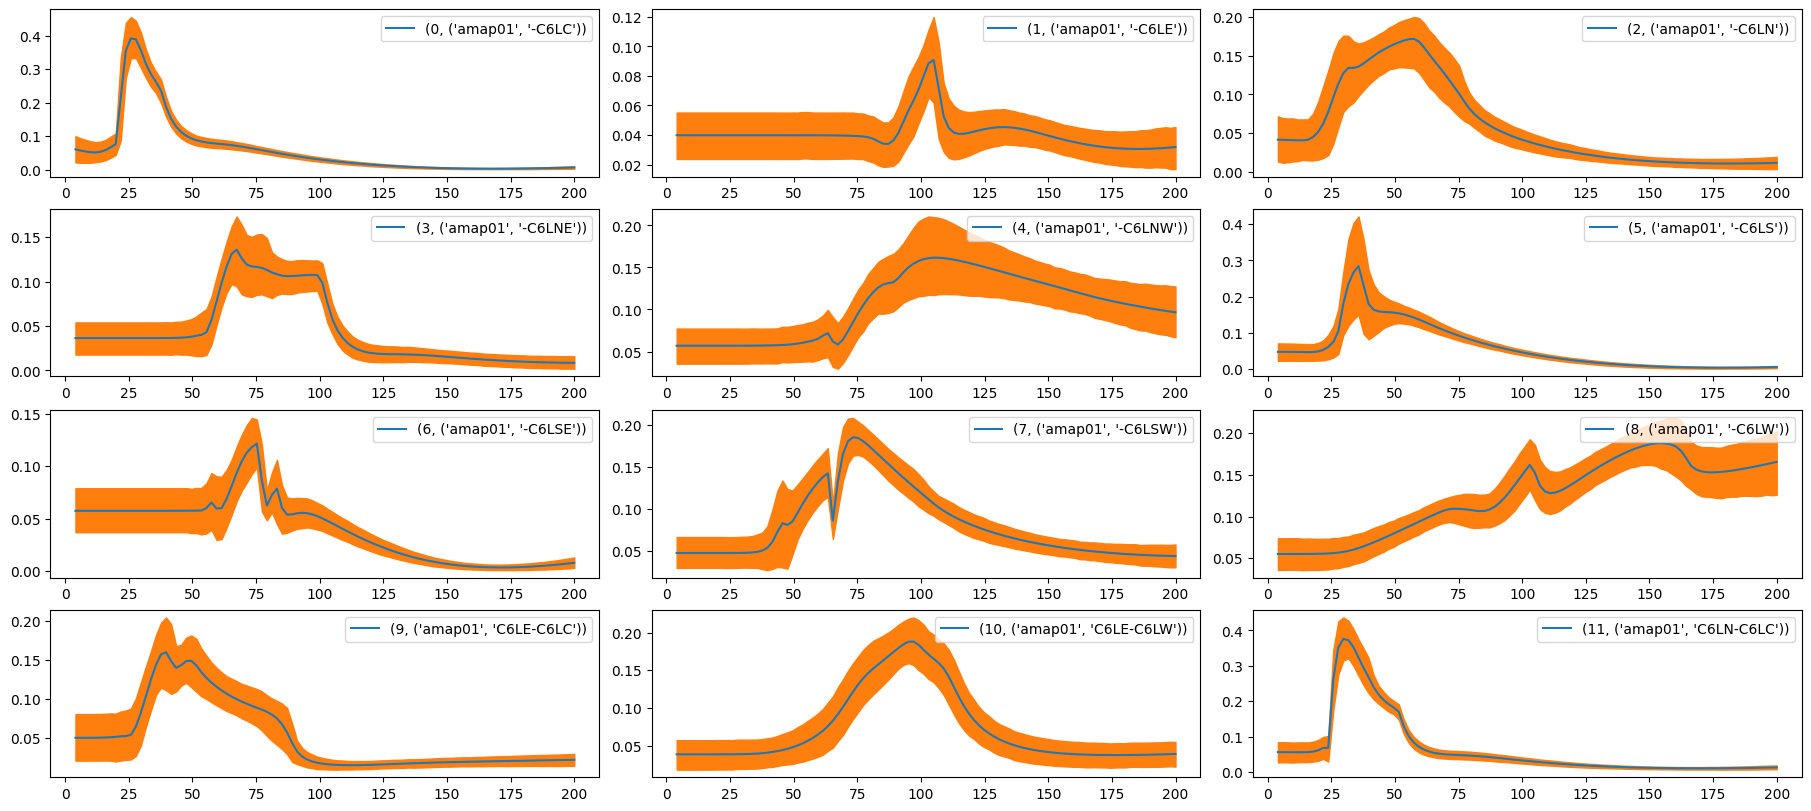

In [48]:
nrows = 4
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 2 * nrows), constrained_layout=True)

for i in range(12):
    ax = axes[i // ncols, i % ncols]
    sns.lineplot(x=x[:, 0, i, 0], y=entropy_adj_map[:, i], label=f"{i, combinations_inv[i]}", ax=ax)
    ax.fill_between(
    x[:, 0, i, 0],
    entropy_adj_hpdi[:, 0, i],
    entropy_adj_hpdi[:, 1, i],
    color="C1",
    label="95% HPDI"
    )

In [49]:
y_map.shape

(100, 168, 6)

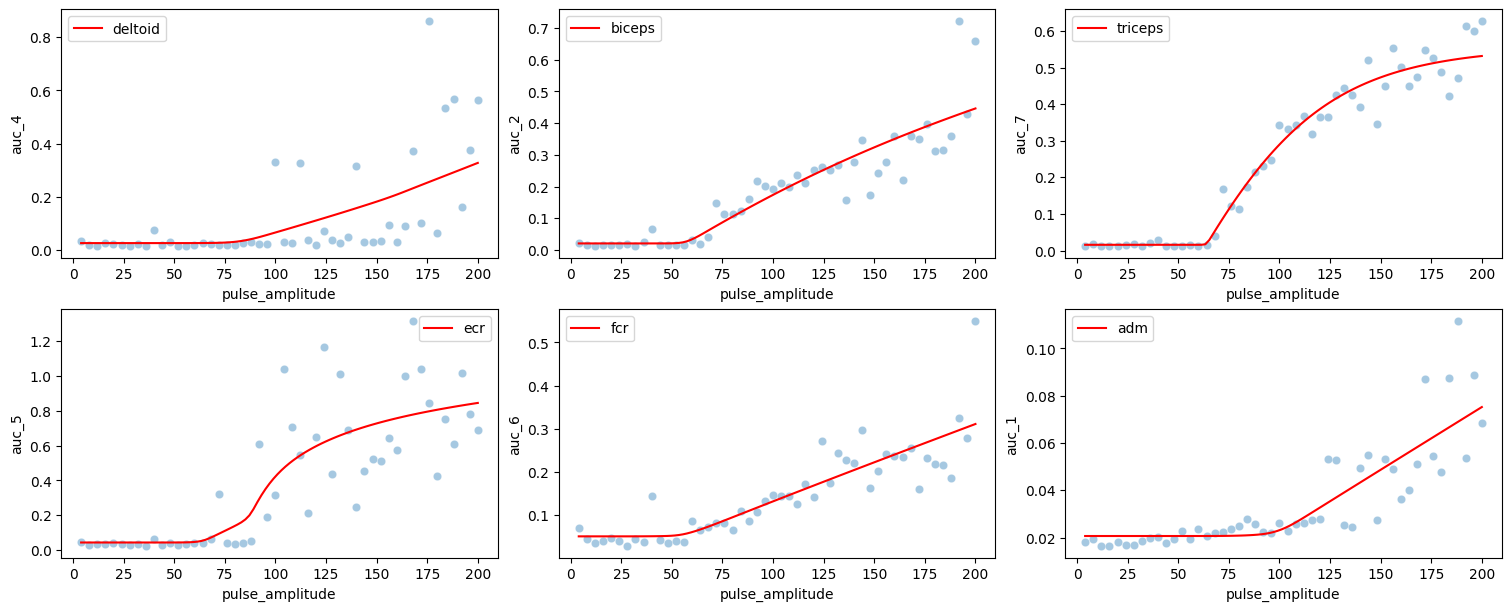

In [50]:
c_ind = 4
c = combinations[c_ind]

ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_muscles)))

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), constrained_layout=True)

for i in range(n_muscles):
    muscle_ind = i
    muscle = muscles[muscle_ind]
    ax = axes[i // ncols, i % ncols]
    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[muscles_map[muscle]] / y_max[0, 0, c_ind, muscle_ind], ax=ax, alpha=.4)
    sns.lineplot(x=x[:, 0, c_ind, 0], y=y_map[:, c_ind, muscle_ind] / y_max[0, 0, c_ind, muscle_ind], ax=ax, color="r", label=f"{muscle}")

In [51]:
entropy_adj.shape

(100, 24000, 168)

In [52]:
entropy_adj.shape

(100, 24000, 168)

In [53]:
def _process_selectivity(keep_positions: list, threshold: int):
    pr = []
    mask = []
    heat_map = []

    for i, i_pos in enumerate(keep_positions):
        curr_pr = []
        curr_mask = []
        curr_heat_map = []

        for j, j_pos in enumerate(keep_positions):
            if i == j:
                curr_pr.append(0)
                curr_mask.append(False)
                curr_heat_map.append("D")
                continue

            i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
            j_com = [(j, c) for j, c in enumerate(combinations) if c[1] == j_pos]

            i_com = sorted(i_com, key=lambda x: x[1][0])
            j_com = sorted(j_com, key=lambda x: x[1][0])

            i_sub = set([v[1][0] for v in i_com])
            j_sub = set([v[1][0] for v in j_com])
            common_sub = i_sub.intersection(j_sub)

            i_ind = [v[0] for v in i_com if v[1][0] in common_sub]
            j_ind = [v[0] for v in j_com if v[1][0] in common_sub]

            if not len(common_sub) or len(common_sub) < threshold:
                curr_pr.append(0)
                curr_mask.append(False)
                curr_heat_map.append(f"NA:{len(common_sub)}")
                continue

            curr_mask.append(True)

            ## Distributions
            i_entropy = entropy_adj[..., i_ind]
            i_entropy = i_entropy.mean(axis=-1)
            i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
            i_entropy = i_entropy[i_amp_ind, :]

            j_entropy = entropy_adj[..., j_ind]
            j_entropy = j_entropy.mean(axis=-1)
            j_amp_ind = np.argmax(j_entropy.mean(axis=-1))
            j_entropy = j_entropy[j_amp_ind, :]

            # diff should be > 0 for i to be more selective than j
            diff_entropy = i_entropy - j_entropy
            pr_entropy = (diff_entropy > 0).mean()
            curr_pr.append(pr_entropy)
            curr_heat_map.append(f"{pr_entropy:.2f}:{len(common_sub)}")

        pr.append(curr_pr)
        mask.append(curr_mask)
        heat_map.append(curr_heat_map)

    pr = np.array(pr)
    mask = np.array(mask)
    heat_map = np.array(heat_map)

    return pr, mask, heat_map

In [54]:
selectivity_score = {}

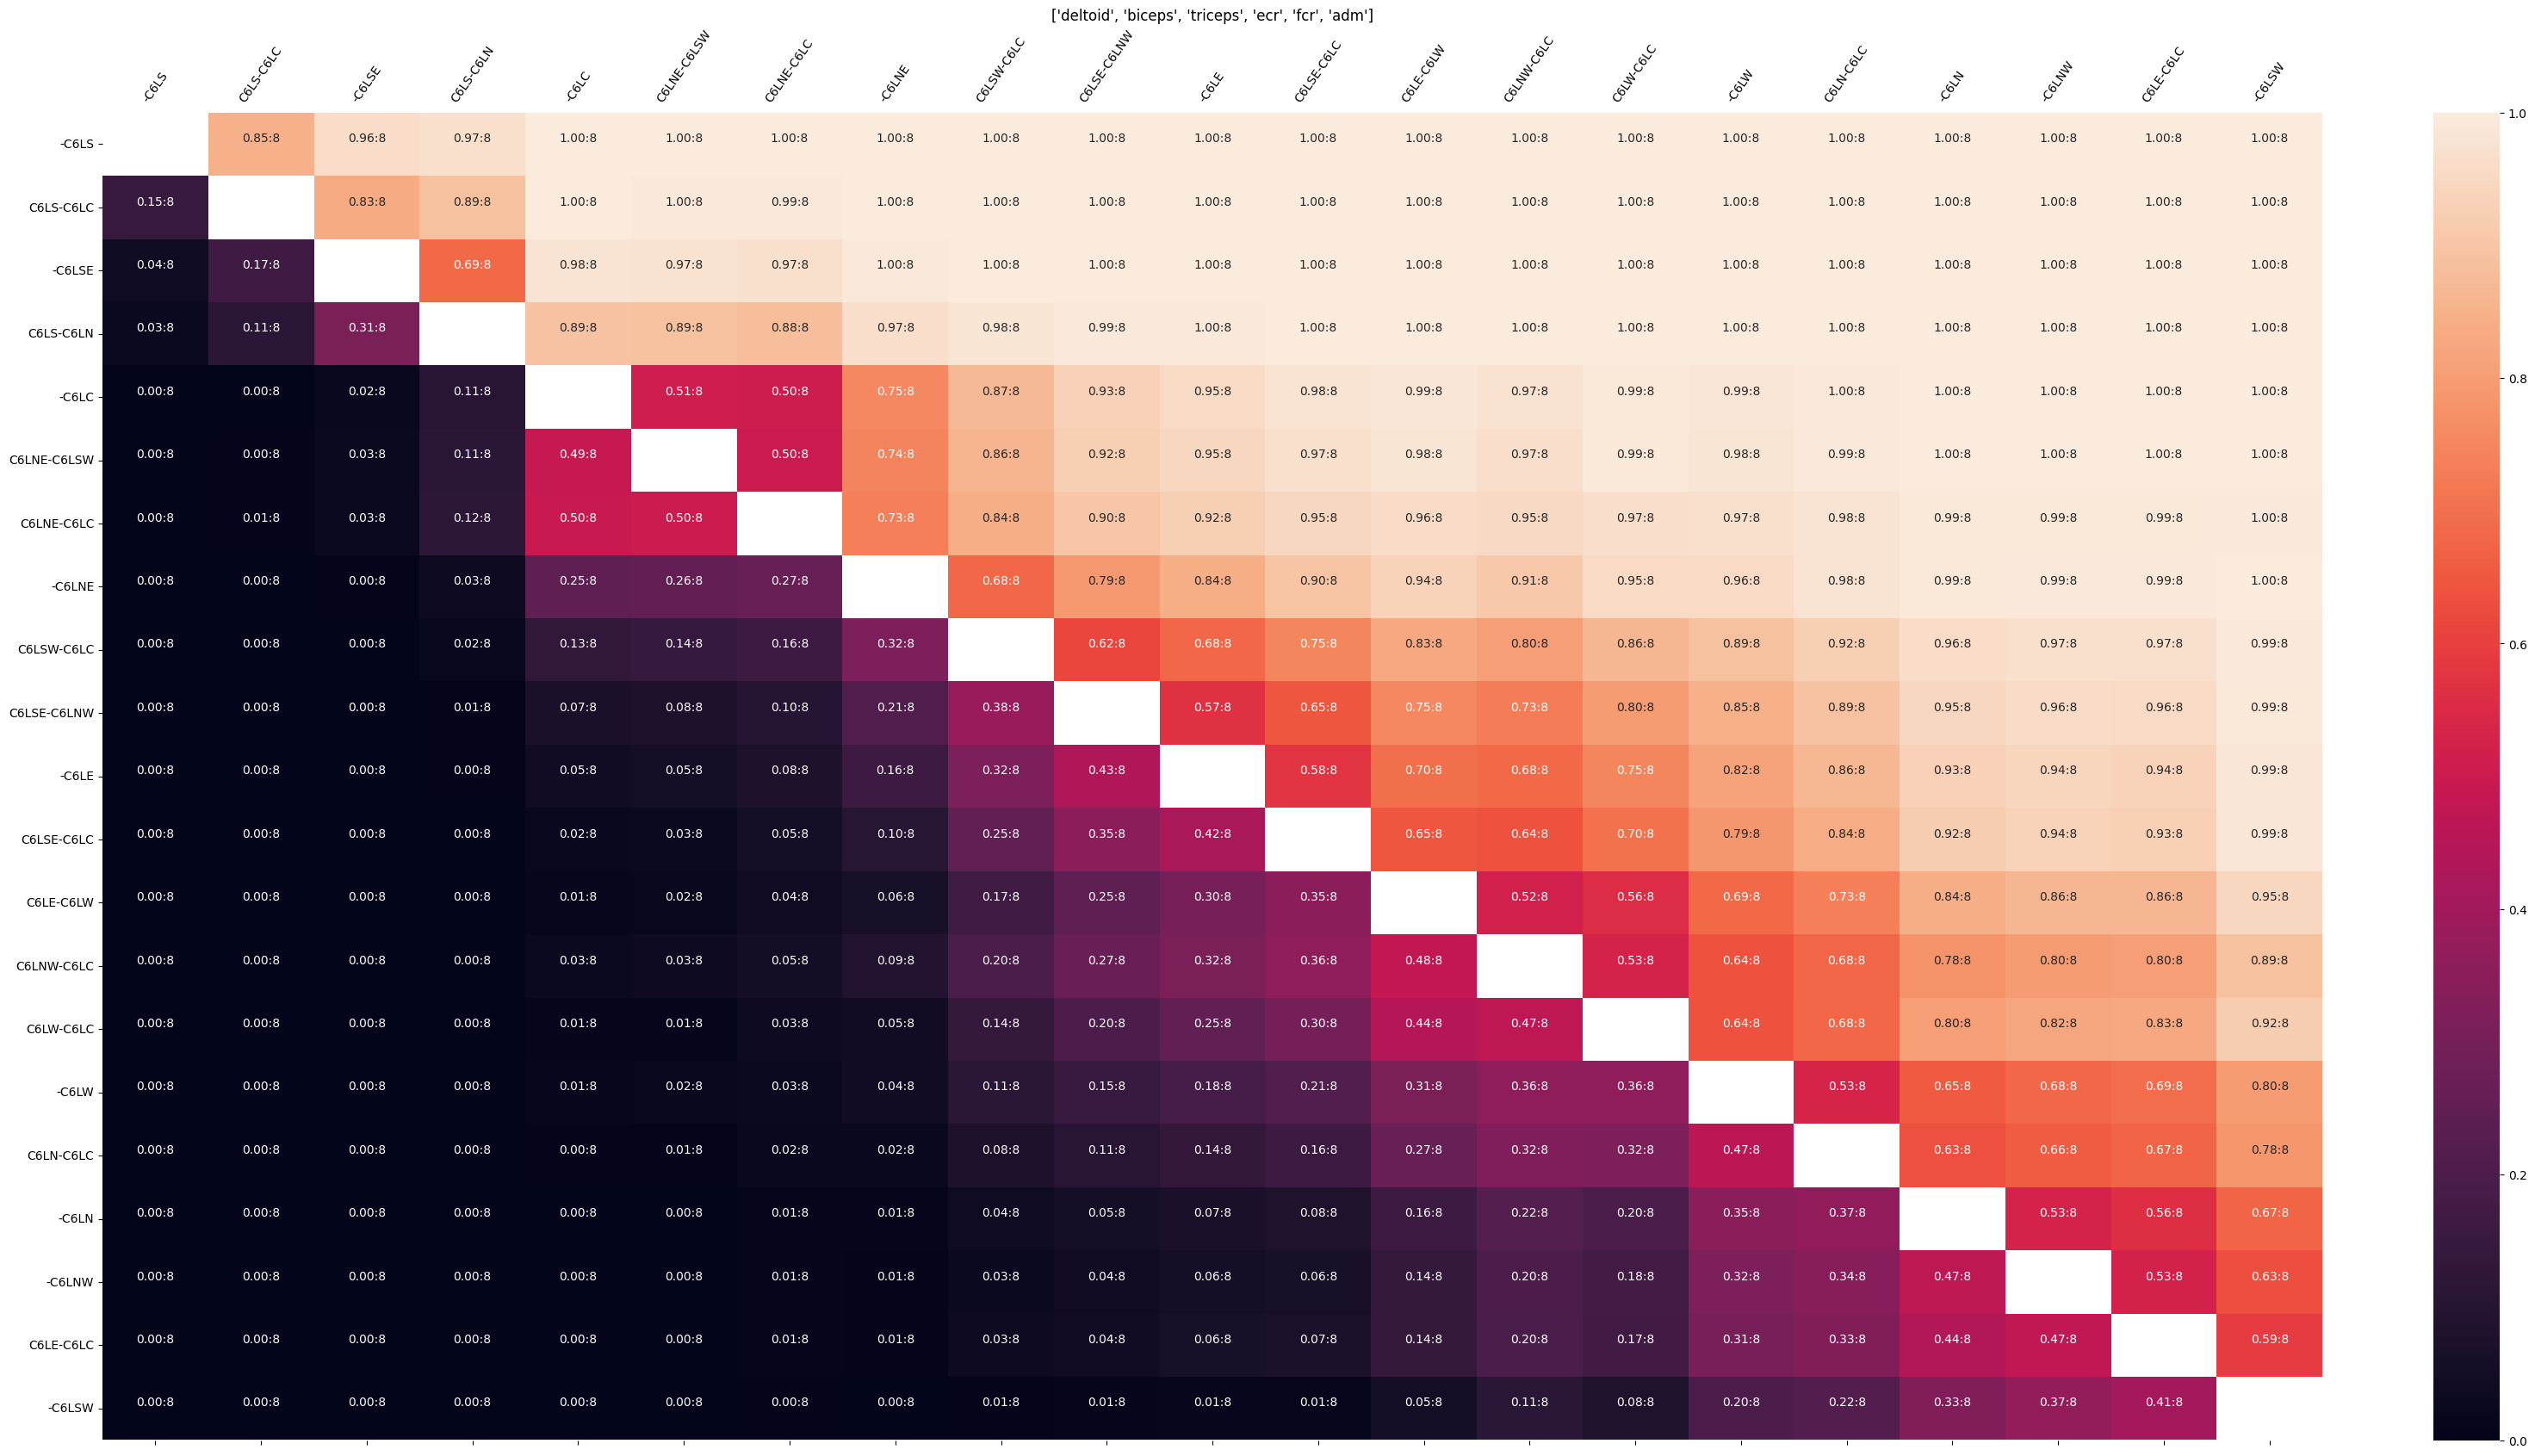

In [55]:
keep_muscles = muscles

keep_positions = positions
n_positions = len(keep_positions)

keep_positions_inv = encoder_dict[model.features[0]].inverse_transform(np.array(positions)).tolist()

pr, mask, heat_map = _process_selectivity(
    keep_positions=keep_positions, threshold=1
)

plt.figure(figsize=(1.4 * n_positions, .8 * n_positions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_positions_inv)[ind],
    yticklabels=np.array(keep_positions_inv)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=55)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [56]:
key = "all"
selectivity_score[key] = {}

for i, c in enumerate(np.array(keep_positions_inv)[ind].tolist()):
    selectivity_score[key][c] = [n_positions - i]

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]
    c_inv = keep_positions_inv[i]
    selectivity_score[key][c_inv].append(i_entropy.mean())

selectivity_score[key]

{'-C6LS': [21, 0.2903247651715714],
 'C6LS-C6LC': [20, 0.26887136934498423],
 '-C6LSE': [19, 0.2575988672407379],
 'C6LS-C6LN': [18, 0.25096967989076246],
 '-C6LC': [17, 0.23268143898288265],
 'C6LNE-C6LSW': [16, 0.2324632170328601],
 'C6LNE-C6LC': [15, 0.2320903543221003],
 '-C6LNE': [14, 0.22398977109021517],
 'C6LSW-C6LC': [13, 0.2177950367122991],
 'C6LSE-C6LNW': [12, 0.21403629898769463],
 '-C6LE': [11, 0.2119659033097851],
 'C6LSE-C6LC': [10, 0.20987966388263757],
 'C6LE-C6LW': [9, 0.20599348634109976],
 'C6LNW-C6LC': [8, 0.20514777295135506],
 'C6LW-C6LC': [7, 0.20421033613178027],
 '-C6LW': [6, 0.19991807651020502],
 'C6LN-C6LC': [5, 0.1983765140881845],
 '-C6LN': [4, 0.19427478682188964],
 '-C6LNW': [3, 0.19318029903616563],
 'C6LE-C6LC': [2, 0.19267854657320477],
 '-C6LSW': [1, 0.18958825198704593]}

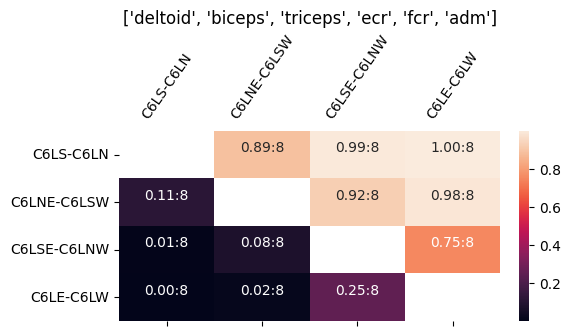

In [57]:
# Diameters
keep_muscles = muscles
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] != "C"]
keep_positions = encoder_dict[model.features[0]].transform(np.array(keep_positions_inv)).tolist()

n_positions = len(keep_positions)

pr, mask, heat_map = _process_selectivity(
    keep_positions=keep_positions, threshold=1
)

plt.figure(figsize=(1.4 * n_positions, .8 * n_positions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_positions_inv)[ind],
    yticklabels=np.array(keep_positions_inv)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=55)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [58]:
key = "diameters"
selectivity_score[key] = {}

for i, c in enumerate(np.array(keep_positions_inv)[ind].tolist()):
    selectivity_score[key][c] = [n_positions - i]

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]
    c_inv = keep_positions_inv[i]
    selectivity_score[key][c_inv].append(i_entropy.mean())

selectivity_score[key]

{'C6LS-C6LN': [4, 0.25096967989076246],
 'C6LNE-C6LSW': [3, 0.2324632170328601],
 'C6LSE-C6LNW': [2, 0.21403629898769463],
 'C6LE-C6LW': [1, 0.20599348634109976]}

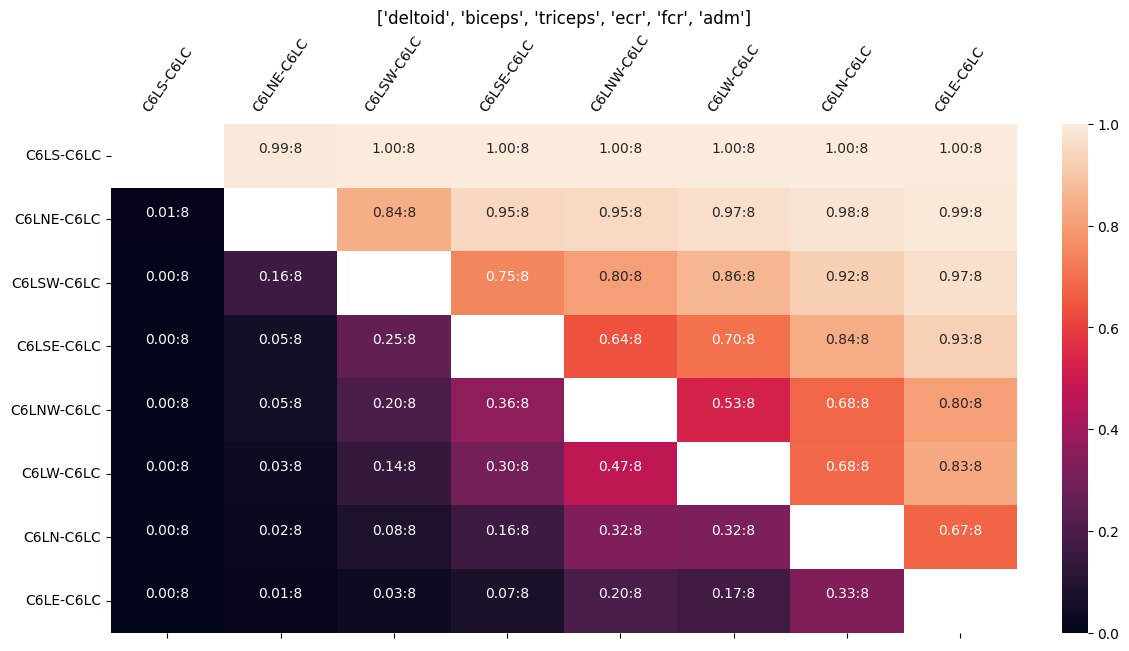

In [59]:
# Radii
keep_muscles = muscles
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] == "C"]
keep_positions = encoder_dict[model.features[0]].transform(np.array(keep_positions_inv)).tolist()

n_positions = len(keep_positions)

pr, mask, heat_map = _process_selectivity(
    keep_positions=keep_positions, threshold=1
)

plt.figure(figsize=(1.4 * n_positions, .8 * n_positions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_positions_inv)[ind],
    yticklabels=np.array(keep_positions_inv)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=55)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [60]:
key = "radii"
selectivity_score[key] = {}

for i, c in enumerate(np.array(keep_positions_inv)[ind].tolist()):
    selectivity_score[key][c] = [n_positions - i]

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]
    c_inv = keep_positions_inv[i]
    selectivity_score[key][c_inv].append(i_entropy.mean())

selectivity_score[key]

{'C6LS-C6LC': [8, 0.26887136934498423],
 'C6LNE-C6LC': [7, 0.2320903543221003],
 'C6LSW-C6LC': [6, 0.2177950367122991],
 'C6LSE-C6LC': [5, 0.20987966388263757],
 'C6LNW-C6LC': [4, 0.20514777295135506],
 'C6LW-C6LC': [3, 0.20421033613178027],
 'C6LN-C6LC': [2, 0.1983765140881845],
 'C6LE-C6LC': [1, 0.19267854657320477]}

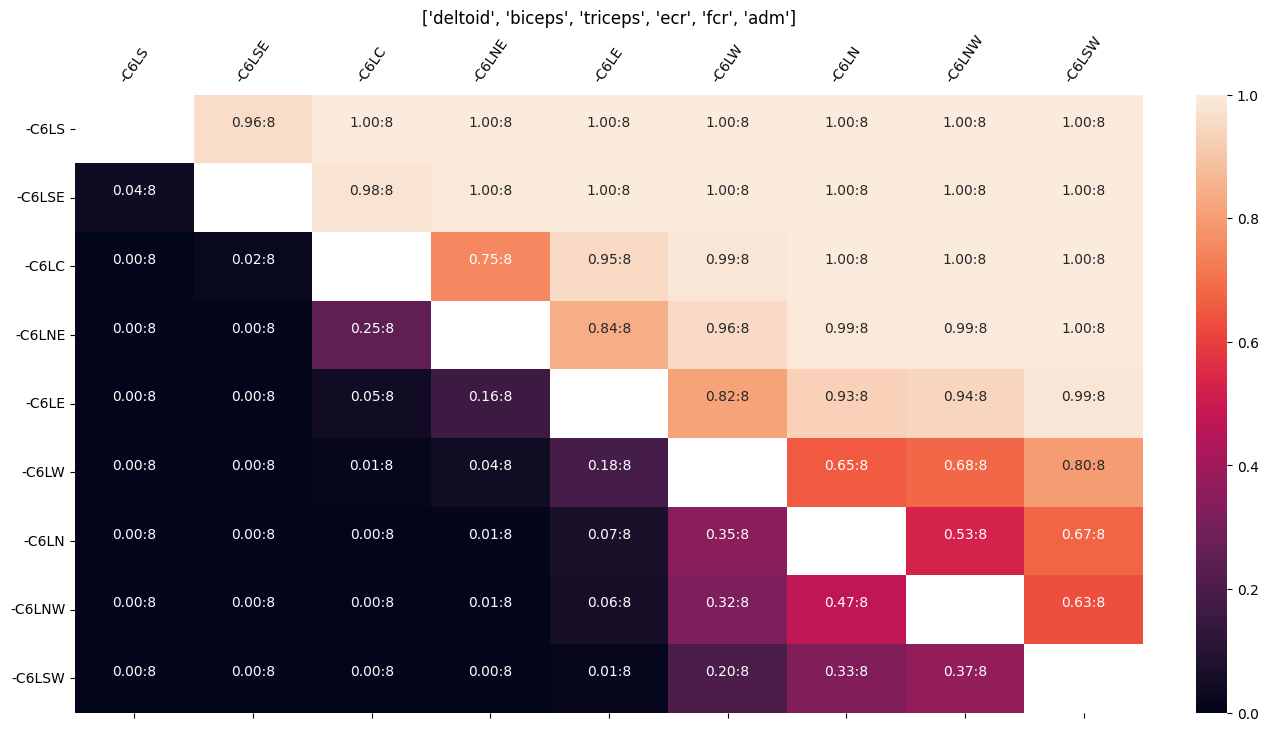

In [61]:
# Vertices
keep_muscles = muscles
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] == ""]
keep_positions = encoder_dict[model.features[0]].transform(np.array(keep_positions_inv)).tolist()

n_positions = len(keep_positions)

pr, mask, heat_map = _process_selectivity(
    keep_positions=keep_positions, threshold=1
)

plt.figure(figsize=(1.4 * n_positions, .8 * n_positions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_positions_inv)[ind],
    yticklabels=np.array(keep_positions_inv)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=55)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [62]:
key = "vertices"
selectivity_score[key] = {}

for i, c in enumerate(np.array(keep_positions_inv)[ind].tolist()):
    selectivity_score[key][c] = [n_positions - i]

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]
    c_inv = keep_positions_inv[i]
    selectivity_score[key][c_inv].append(i_entropy.mean())

selectivity_score[key]

{'-C6LS': [9, 0.2903247651715714],
 '-C6LSE': [8, 0.2575988672407379],
 '-C6LC': [7, 0.23268143898288265],
 '-C6LNE': [6, 0.22398977109021517],
 '-C6LE': [5, 0.2119659033097851],
 '-C6LW': [4, 0.19991807651020502],
 '-C6LN': [3, 0.19427478682188964],
 '-C6LNW': [2, 0.19318029903616563],
 '-C6LSW': [1, 0.18958825198704593]}

In [63]:
positions

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [64]:
efficacy_score[key]

{'-C6LS': [9, 112.97451662302753],
 '-C6LC': [8, 115.6346878916104],
 '-C6LN': [7, 128.37375168070494],
 '-C6LSE': [6, 138.54825828595372],
 '-C6LSW': [5, 142.45991855972105],
 '-C6LNW': [4, 146.53182955341543],
 '-C6LNE': [3, 153.92762546965983],
 '-C6LW': [2, 162.34223242108442],
 '-C6LE': [1, 172.62143594596125]}

In [65]:
keep_positions_inv

['-C6LC',
 '-C6LE',
 '-C6LN',
 '-C6LNE',
 '-C6LNW',
 '-C6LS',
 '-C6LSE',
 '-C6LSW',
 '-C6LW']

Text(0.5, 0, 'Efficacy ${µA}^{-1}$')

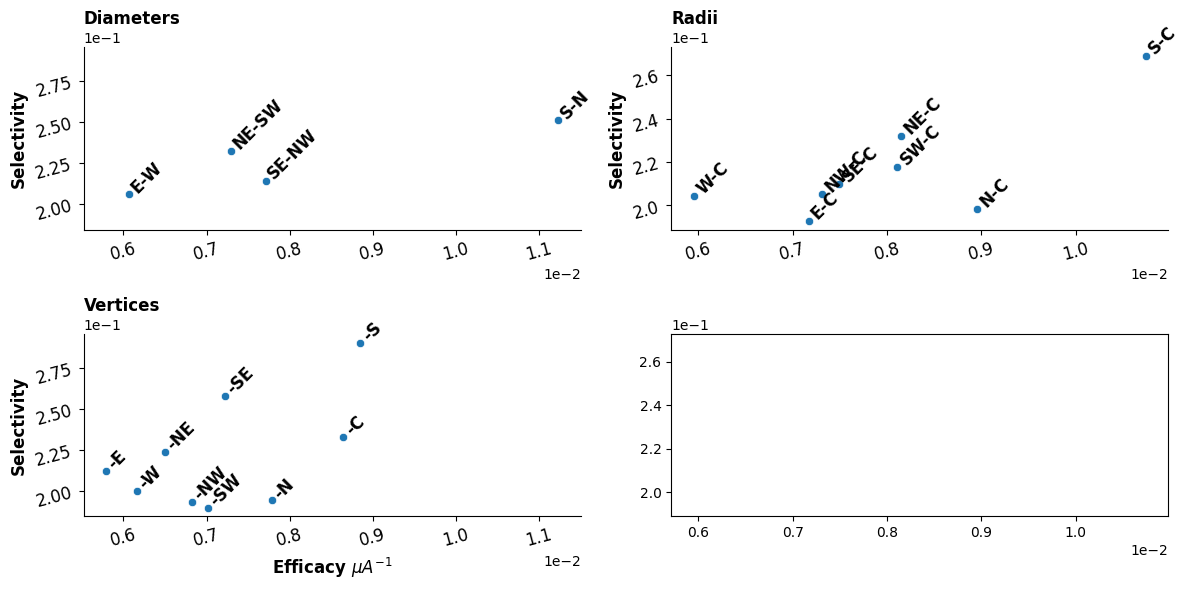

In [66]:
tick_size = 12
axis_label_size = 12

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6), tight_layout=True, squeeze=False, sharex="col", sharey="col")

ax = axes[0, 0]
key = "diameters"
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] != "C"]
keep_positions_inv_adj = [c_inv.split("-")[0][3:] + "-" + c_inv.split("-")[1][3:] for c_inv in keep_positions_inv]

x = [1 / efficacy_score[key][c_inv][1] for c_inv in keep_positions_inv]
y = [selectivity_score[key][c_inv][1] for c_inv in keep_positions_inv]

sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(keep_positions_inv)):
    ax.text(
        x[i]+0.0001,
        y[i]+0.0005,
        keep_positions_inv_adj[i],
        horizontalalignment='left',
        size='large',
        color='black',
        weight='semibold',
        rotation=45,
        wrap=True
    )
ax.set_title("Diameters", fontweight="bold", size=axis_label_size, loc="left")
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Selectivity", size=axis_label_size, weight="bold")
ax.set_xlabel("Efficacy ${µA}^{-1}$", size=axis_label_size, weight="bold")


ax = axes[0, 1]
key = "radii"
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] == "C"]
keep_positions_inv_adj = [c_inv.split("-")[0][3:] + "-" + c_inv.split("-")[1][3:] for c_inv in keep_positions_inv]

x = [1 / efficacy_score[key][c_inv][1] for c_inv in keep_positions_inv]
y = [selectivity_score[key][c_inv][1] for c_inv in keep_positions_inv]

sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(keep_positions_inv)):
    ax.text(
        x[i]+0.0001,
        y[i]+0.0005,
        keep_positions_inv_adj[i],
        horizontalalignment='left',
        size='large',
        color='black',
        weight='semibold',
        rotation=45,
        wrap=True
    )
ax.set_title("Radii", fontweight="bold", size=axis_label_size, loc="left")
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Selectivity", size=axis_label_size, weight="bold")
ax.set_xlabel("Efficacy ${µA}^{-1}$", size=axis_label_size, weight="bold")


ax = axes[1, 0]
key = "vertices"
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] == ""]
keep_positions_inv_adj = [c_inv.split("-")[0][3:] + "-" + c_inv.split("-")[1][3:] for c_inv in keep_positions_inv]

x = [1 / efficacy_score[key][c_inv][1] for c_inv in keep_positions_inv]
y = [selectivity_score[key][c_inv][1] for c_inv in keep_positions_inv]

sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(keep_positions_inv)):
    ax.text(
        x[i]+0.0001,
        y[i]+0.0005,
        keep_positions_inv_adj[i],
        horizontalalignment='left',
        size='large',
        color='black',
        weight='semibold',
        rotation=45,
        wrap=True
    )
ax.set_title("Vertices", fontweight="bold", size=axis_label_size, loc="left")
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Selectivity", size=axis_label_size, weight="bold")
ax.set_xlabel("Efficacy ${µA}^{-1}$", size=axis_label_size, weight="bold")


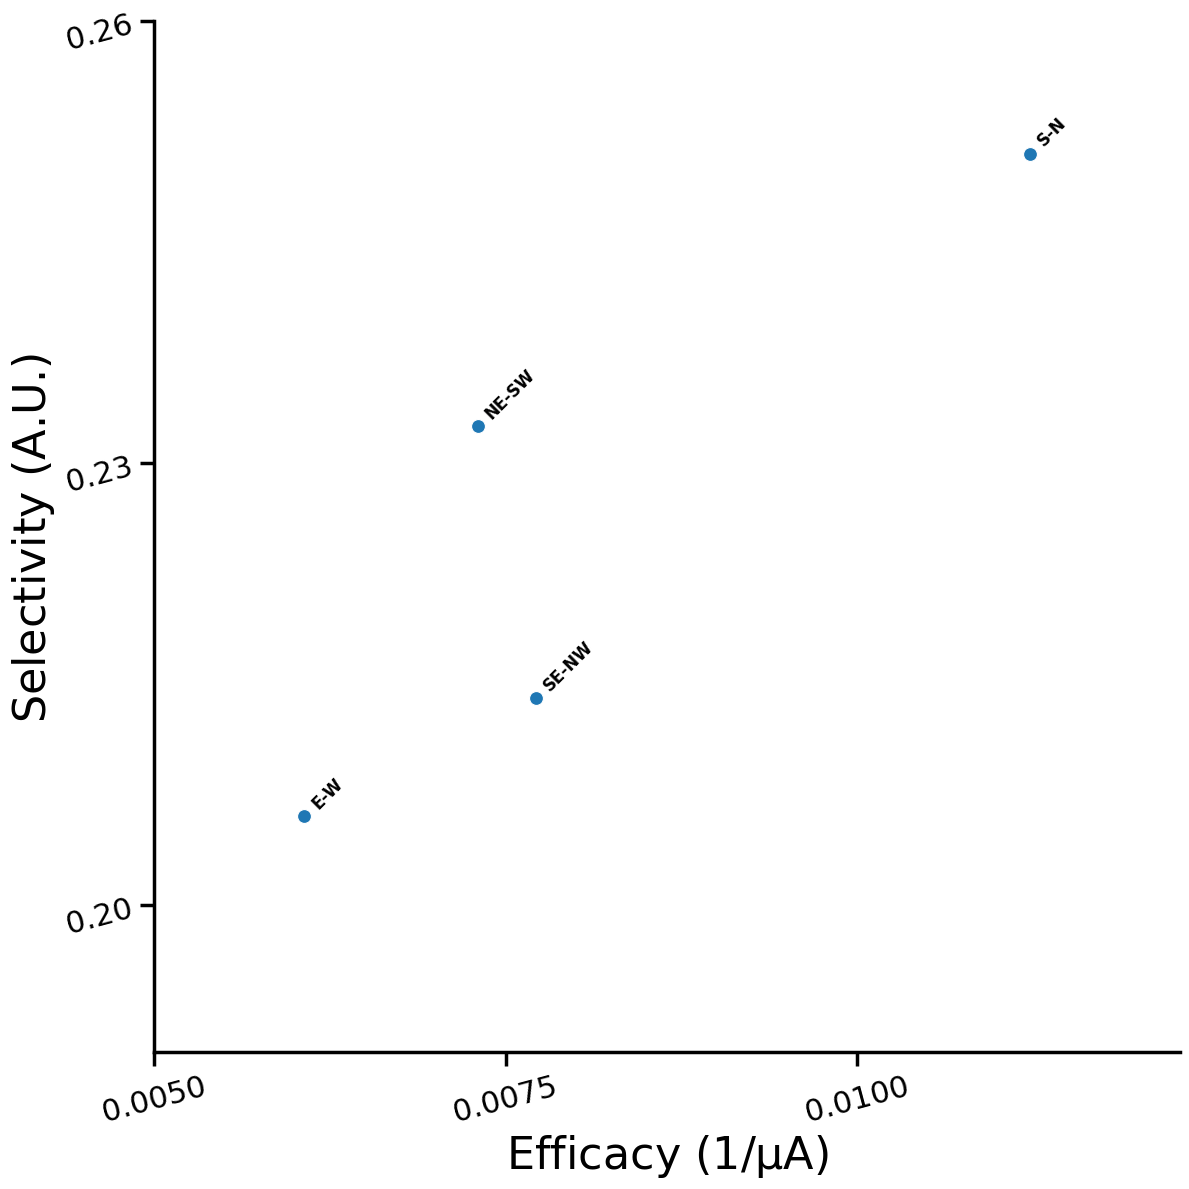

In [67]:
fw = "normal"

axis_label_size = 32
tick_size = 22
axes_width = 2.5

marker_len = 10
marker_width = axes_width

pt_size = 100

nrows, ncols = 1, 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), tight_layout=True, squeeze=False)

ax = axes[0, 0]
key = "diameters"
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] != "C"]
keep_positions_inv_adj = [c_inv.split("-")[0][3:] + "-" + c_inv.split("-")[1][3:] for c_inv in keep_positions_inv]

x = [1 / efficacy_score[key][c_inv][1] for c_inv in keep_positions_inv]
y = [selectivity_score[key][c_inv][1] for c_inv in keep_positions_inv]

sns.scatterplot(x=x, y=y, ax=ax, s=pt_size)
for i in range(len(keep_positions_inv)):
    ax.text(
        x[i]+0.0001,
        y[i]+0.0005,
        keep_positions_inv_adj[i],
        horizontalalignment='left',
        size='large',
        color='black',
        weight='semibold',
        rotation=45,
        wrap=True
    )

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size,
    length=marker_len,
    width=marker_width
)
ax.set_xlabel("Efficacy $($1/µA$)$", size=axis_label_size, fontweight=fw)
ax.set_ylabel("Selectivity $($A.U.$)$", size=axis_label_size, fontweight=fw)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# ax.ticklabel_format(axis='x', style='sci', scilimits=(0,4))
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,4))

ax.set_xlim(left=0.57/100, right=1.23 / 100)
ax.set_ylim(bottom=1.9/10)
ax.set_yticks(np.array([2, 2.3, 2.6]) / 10)
ax.set_xticks(np.array([0.5, 0.75, 1]) / 100)

ax.xaxis.offsetText.set_fontsize(tick_size)
ax.yaxis.offsetText.set_fontsize(tick_size)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(axes_width)

fig.savefig("/home/vishu/paper/figs/plane-circ.svg", dpi=600)

In [68]:
x

[0.006066207137221817,
 0.007300384602773682,
 0.011231647577790322,
 0.007713310471720916]

In [69]:
y

[0.20599348634109976,
 0.2324632170328601,
 0.25096967989076246,
 0.21403629898769463]

In [70]:
keep_positions_inv_adj

['E-W', 'NE-SW', 'S-N', 'SE-NW']

In [107]:
keep_muscles = muscles
keep_positions_inv = [c for c in positions_inv if c.split("-")[0] != "" and c.split("-")[1] != "" and c.split("-")[1][-1] != "C"]
keep_positions = encoder_dict[model.features[0]].transform(np.array(keep_positions_inv)).tolist()

keep_positions_inv

['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW']

In [108]:
dst_dir = '/home/vishu/paper/data/circ/'

save_mat = np.array(keep_positions_inv)
fname = 'keep_positions_inv.npy'

dst = os.path.join(dst_dir, fname)

np.save(dst, save_mat)

save_mat

array(['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW'],
      dtype='<U11')

In [109]:
circ_efficacy = None

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    i_a = i_a.mean(axis=-1)

    if circ_efficacy is None:
        circ_efficacy = i_a.reshape(-1, 1)
    else:
        circ_efficacy = np.concatenate([circ_efficacy, i_a.reshape(-1, 1)], axis=-1)

circ_efficacy.shape

(24000, 4)

In [110]:
dst_dir = '/home/vishu/paper/data/circ/'

save_mat = circ_efficacy
fname = 'circ_efficacy.npy'

dst = os.path.join(dst_dir, fname)

np.save(dst, save_mat)

save_mat.mean(axis=0)

array([164.84765149, 136.97908458,  89.03413262, 129.64601952])

In [113]:
x

[0.006066207137221817,
 0.007300384602773682,
 0.011231647577790322,
 0.007713310471720916]

In [112]:
1 / (circ_efficacy.mean(axis=0))

array([0.00606621, 0.00730038, 0.01123165, 0.00771331])

In [111]:
(1 / circ_efficacy).mean(axis=0)

array([0.00606888, 0.00730277, 0.01124797, 0.00772139])

In [114]:
circ_selectivity = None

for i, i_pos in enumerate(keep_positions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos]
    i_ind = [v[0] for v in i_com]
    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)
    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
    i_entropy = i_entropy[i_amp_ind, :]

    if circ_selectivity is None:
        circ_selectivity = i_entropy
        circ_selectivity = circ_selectivity.reshape(-1, 1)
    else:
        circ_selectivity = np.concatenate([circ_selectivity, i_entropy.reshape(-1, 1)], axis=-1)

circ_selectivity.shape

(24000, 4)

In [115]:
dst_dir = '/home/vishu/paper/data/circ/'

save_mat = circ_selectivity
fname = 'circ_selectivity.npy'

dst = os.path.join(dst_dir, fname)

np.save(dst, save_mat)

save_mat.mean(axis=0)

array([0.20599349, 0.23246322, 0.25096968, 0.2140363 ])

In [116]:
y

[0.20599348634109976,
 0.2324632170328601,
 0.25096967989076246,
 0.21403629898769463]